In [1]:
from elasticsearch import Elasticsearch
import json
import requests

import eslogin

import datetime
import time

import numpy as np
from numpy.random import randn
import pandas as pd
from scipy import stats
import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns

import math

from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
mpl.style.use('ggplot')

In [2]:
print mpl.__version__

1.4.3


#Import data

In [3]:
clicks_uniq = pd.read_csv("../data/clicks_uniq_150610.tab",sep='\t',index_col=0,encoding='utf-8')
adShows_uniq = pd.read_csv("../data/adShows_uniq_150610.tab",sep='\t',index_col=0,encoding='utf-8')
duplicate_id = set(adShows_uniq['id']) - set(clicks_uniq['id'])
adShows_uniq_only = adShows_uniq.loc[adShows_uniq['id'].apply(lambda x: x in duplicate_id), :]

In [5]:
data = pd.concat([clicks_uniq[['ai','br','co','cty','rgn','plfm','pv','dt','sdpt','isp','ernc','dp','vw_drtn','vw_perc','cr','created_at','et']],adShows_uniq_only[['ai','br','co','cty','rgn','plfm','pv','dt','sdpt','isp','ernc','dp','vw_drtn','vw_perc','cr','created_at','et']]], axis=0)

In [6]:
def get_date(timestring):
    mytime = timestring.split('.')[0]
    return datetime.datetime.strptime(mytime, '%Y-%m-%dT%X')
data['created_at'] = data['created_at'].apply(get_date)

In [93]:
data2 = data[data['created_at'].apply(lambda x:(x.month == 5 or x.month == 6))]

In [94]:
data2['br_short'] = data2['br'].apply(lambda x:x.split()[0])
data2['click'] = data2['et'].apply(lambda x:x == 'AD_CLICK')

In [95]:
data2.shape

(18729, 19)

In [25]:
ad_type = pd.read_csv("../data/zenit_creatives_parsed.tab",sep='\t',encoding='utf-8')

In [26]:
ad_type.columns[0]

u'cr'

In [46]:
ad_type['ad_type'][ad_type['cr'].apply(lambda x: x == 157)].values[0]

u'tile_and_text'

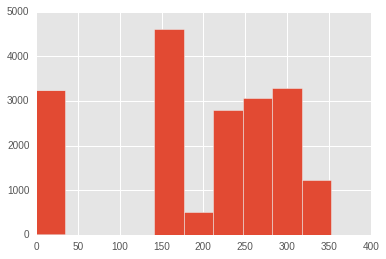

In [96]:
data2['cr'].hist()

In [97]:
data2['plfm'].value_counts()

ios        4928
android    4699
dtype: int64

In [70]:
def get_ad_type(cr_id):
    if cr_id > 0 and cr_id in ad_type['cr']:
        return ad_type['ad_type'][ad_type['cr'].apply(lambda x: x == cr_id)].values[0]
    else:
        return np.NaN
get_ad_type(157)

u'tile_and_text'

In [98]:
data2 = pd.merge(data2, ad_type, left_on ='cr', right_on ='cr', how='left')

In [99]:
data2['day'] = data2['created_at'].apply(lambda x:x.day)

In [100]:
data2['time'] = data2['created_at'].apply(lambda x:x.hour)

In [101]:
pd.options.display.max_rows = 3
pd.options.display.max_columns = 30
data2

,ai,br,co,cty,rgn,plfm,pv,dt,sdpt,isp,ernc,dp,vw_drtn,vw_perc,cr,created_at,et,br_short,click,name,ad_type,day,time
0,51,Other 0.0,GBR,Eastbourne,GBR-E2,NaN,unknown,other,1,BT,210000,300000,0,0,157,2015-05-10 04:41:11,AD_CLICK,Other,True,Anyoption #2,tile_and_text,10,4
1,NaN,Safari 10.3.1.2267,NGA,Lagos,NGA-05,NaN,unknown,other,0,Globacom Ltd,210000,300000,0,0,157,2015-05-09 06:35:35,AD_CLICK,Safari,True,Anyoption #2,tile_and_text,9,6
2,NaN,Safari 10.3.1.2558,NGA,Lagos,NGA-05,NaN,unknown,other,0,Globacom Ltd,210000,300000,0,0,157,2015-05-09 06:59:06,AD_CLICK,Safari,True,Anyoption #2,tile_and_text,9,6
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


#Specify two apps

In [86]:
features = ['click','ai','br_short','co','cty','rgn','plfm','pv','dt','sdpt','isp','ernc','dp','ad_type','day','time']

In [102]:
data2_Diretta_Calcio = data2.loc[data2['ai'].apply(lambda x:(x == 67 or x == 68)),features]

In [103]:
data2_Diretta_Calcio.shape

(1163, 16)

In [104]:
data2_Diretta_Calcio['click'].value_counts()

True     669
False    494
dtype: int64

In [105]:
data2_Team_Manchester = data2.loc[data2['ai'].apply(lambda x:(x == 53 or x == 54)),features]

In [106]:
data2_Team_Manchester.shape

(2584, 16)

In [107]:
data2_Team_Manchester['click'].value_counts()

False    2156
True      428
dtype: int64

#Machine learning on these two apps

In [114]:
data2_Diretta_Calcio.index = range(data2_Diretta_Calcio.shape[0])

In [159]:
def cty_parser(city):
    if type(city) == float:
        return city
    else:
        return city.encode('ascii', 'ignore').decode('ascii')
data2_Diretta_Calcio['cty'].apply(cty_parser)

0                      Maidenhead
1                         Watford
2                        Massafra
3                             NaN
4                           Turin
5                         Palermo
6                             Rho
7                           Milan
8                             NaN
9                          Verona
10                            NaN
11                         Naples
12                            NaN
13          Giugliano In Campania
14                            NaN
15                          Padua
16                            NaN
17                         Verona
18                        Brescia
19                            NaN
20                            NaN
21                            NaN
22                           Bari
23                            NaN
24                            NaN
25                        Carrara
26                         Naples
27                            NaN
28                            NaN
29            

In [163]:
data2_Diretta_Calcio_expand = pd.concat([data2_Diretta_Calcio[['click']],pd.get_dummies(data2_Diretta_Calcio['br_short'], dummy_na=True, prefix='br'),
                                         pd.get_dummies(data2_Diretta_Calcio['co'], dummy_na=True, prefix='co'),
                                         pd.get_dummies(data2_Diretta_Calcio['cty'].apply(cty_parser), dummy_na=True, prefix='cty'),
                                         pd.get_dummies(data2_Diretta_Calcio['rgn'], dummy_na=True, prefix='rgn'),
                                         pd.get_dummies(data2_Diretta_Calcio['plfm'], dummy_na=True, prefix='plfm'),
                                         pd.get_dummies(data2_Diretta_Calcio['pv'], dummy_na=True, prefix='pv'),
                                         pd.get_dummies(data2_Diretta_Calcio['dt'], dummy_na=True, prefix='dt'),
                                         pd.get_dummies(data2_Diretta_Calcio['isp'], dummy_na=True, prefix='isp'),
                                         pd.get_dummies(data2_Diretta_Calcio['ad_type'], dummy_na=True, prefix='ad_type'),
                                         data2_Diretta_Calcio[['ai','sdpt','day','time','ernc','dp']]],axis=1)

In [165]:
data2_Diretta_Calcio_expand.shape

(1163, 370)

In [173]:
train_Diretta_Calcio_Ind = np.random.choice(data2_Diretta_Calcio.shape[0], size=800, replace=False)

In [175]:
train_Diretta_Calcio = data2_Diretta_Calcio_expand.loc[train_Diretta_Calcio_Ind,:]

In [176]:
test_Diretta_Calcio_Ind = []
for i in range(data2_Diretta_Calcio.shape[0]):
    if not i in train_Diretta_Calcio_Ind:
        test_Diretta_Calcio_Ind.append(i)
len(test_Diretta_Calcio_Ind)

363

In [177]:
test_Diretta_Calcio = data2_Diretta_Calcio_expand.loc[test_Diretta_Calcio_Ind,:]